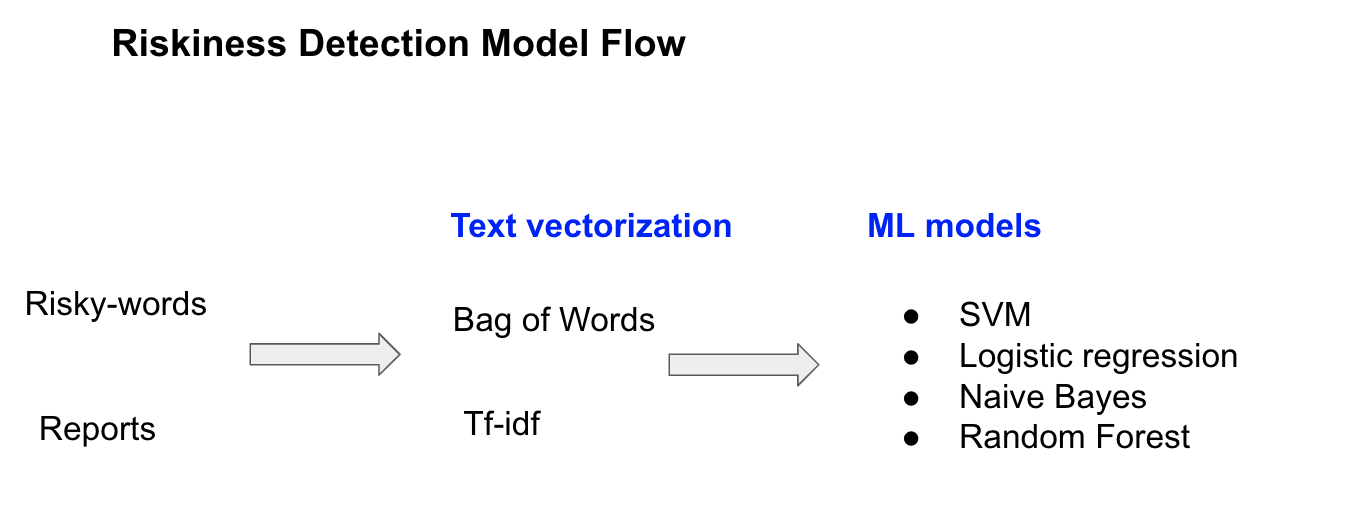

In [1]:
import string
from nltk.corpus import stopwords
import nltk 
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
import numpy as np
import re
from collections import Counter
import csv
from nltk import stem
# import difflib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

#Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/crystal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/crystal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

# Preparation for Abbreviation Dictionary

In [3]:
abbreviation = pd.read_csv("abbreviation_dictionary.csv")

In [4]:
abbreviation.head()

,Name,Form
0,Above Ground Level,AGL
1,Actual Time Of Arrival/Air Traffic Area,ATA
2,Actual Time Of Departure,ATD
3,Aeronautical,AERO
4,Aeronautical Information Manual,AIM


In [5]:
#Create the dictionary
dict_abb = {}
for i in range(len(abbreviation)):   
    word = ' '+abbreviation.iloc[i,1]+' '
    value = ' '+abbreviation.iloc[i,0]+' '
    dict_abb[word] = value
dict_abb = {k.lower(): v.lower() for k, v in dict_abb.items()}

# ASRS dataset

In [6]:
asrs = pd.read_excel('asrs_stratified_sample.xlsx')
# drop rows without labels
asrs.dropna(subset =['riskiness'],inplace = True)
asrs = asrs.reset_index()
asrs.drop(['index','Unnamed: 0'],axis =1,inplace = True)
asrs.head(2)

,acn,year,month,local_time,airport,airport_code,airport_type,airport_name,airport_lat,airport_long,...,atc_steps,assessments,assessments.1,riskiness,report 1,report 1.1,report 2,report 2.1,report 1.2,narra_length
0,1372570,2015,7,1201-1800,JVW.Airport,JVW,Airport,John Bell Williams,32.303341,-90.408493,...,Flight Crew Took Evasive Action,Human Factors,Human Factors,0.0,The winds were variable; favoring either runwa...,NaN,NaN,NaN,C172 instructor pilot reported braking abruptl...,0
1,967887,2011,9,0601-1200,ZZZ.Airport,ZZZ,Airport,NaN,NaN,NaN,...,Aircraft Aircraft Damaged; General Maintenance...,Aircraft,Aircraft,1.0,Upon touchdown; we heard a loud pop followed b...,NaN,NaN,NaN,When a tire blew out on landing; the flight cr...,0


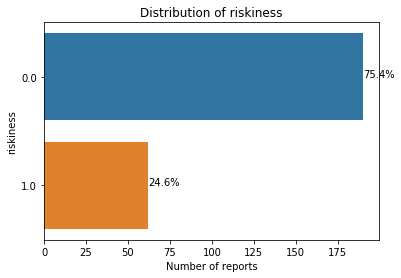

In [7]:
fig = plt.figure(figsize = (6,4))
ax = sns.countplot(y="riskiness", data=asrs)
plt.title('Distribution of riskiness')
plt.xlabel('Number of reports')

total = len(asrs['riskiness'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

## text preprocessing

In [8]:
#decontraction
def decontracted(phrase):
    # specific
    phrase = re.sub(r"that\'s", "that is", phrase)       
    phrase = re.sub(r"go-around", "go around", phrase)  
    # general
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

asrs['report_1_new'] = asrs['report 1'].apply(lambda x: decontracted(x.lower()))

In [9]:
def remove_punc(mess):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ' '+''.join(nopunc)+' '
    return nopunc

string.punctuation = string.punctuation.replace("-", "").replace("'", "")

asrs['report_1_new'] = asrs['report_1_new'].apply(lambda x: remove_punc(x))

In [10]:
def replace_abbreviation(string):
    for k, v in dict_abb.items():
        string = string.replace(k, v)
    return string

asrs['report_1_new'] = asrs['report_1_new'].apply(lambda x: replace_abbreviation(x))

In [11]:
# remove stopwords
stop_words = stopwords.words('english')
common_words =['the','would','could']
stop_words.extend(word for word in common_words if word not in stop_words)

asrs['report_1_new'] = asrs['report_1_new'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words and word != '']))

In [12]:
# lemmantize
lemmatizer = WordNetLemmatizer() 
asrs['report_1_new'] = asrs['report_1_new'].apply(lambda x:  ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [13]:
# concat words
def concat_word(phrase):
    # specific
    phrase = re.sub(r"decision making", "decision-making", phrase)
    phrase = re.sub(r"human factors", "human-factors", phrase)
    phrase = re.sub(r"instrument meteorological conditions", "instrument-meteorological-conditions", phrase)
    phrase = re.sub(r"lost control", "lost-control", phrase)
    phrase = re.sub(r"near miss", "near-miss", phrase)
    phrase = re.sub(r"situational awareness", "situational-awareness", phrase)
    phrase = re.sub(r"anti icing", "anti-icing", phrase)       
    phrase = re.sub(r"off runway", "off-runway", phrase)  
    return phrase

asrs['report_1_new'] = asrs['report_1_new'].apply(lambda x: concat_word(x))

## Creating dictionary of risky words

In [14]:
risky_words = ["Accident","Airspeed","Attitude","broke","broken",
"clipped","collapse","Collision","Communication","Currency",
"damage","Death","Deicing","dent","disoriented","Diverting",
"Emergency","Engine","Error","Failed","failure","Fatal","Fear","fire",
"Hail","Hypoxia","Ice","Icing","impact","Incident","Incursion","Injured","Injury","Life",
"Lightning","Midair","Mistake","Overshoot","Overshot","Oxygen","Proficiency","Regulation","Risk",
"scared","skid","slid","slide","snapped","Spin","Stall","strike","struck","suddenly",
"terminated","Thunderstorm","Turbulence","Undershoot","Weather",
"Decision-making","Human-factors","instrument-meteorological-conditions","lost-control",
"Near-miss","Situational-awareness","Wind-shear","Anti-icing","off-airport","off-runway"]

new_risky_words = ["collapsed","collided","colliding","miscommunication","damaged","deice","deiced",
                   "diverted","divert","fearing","feared","fail","failing"]

In [15]:
risky_words = risky_words + new_risky_words
risky_words =[char.lower() for char in risky_words]

## Text vectorization 1: bag-of-words

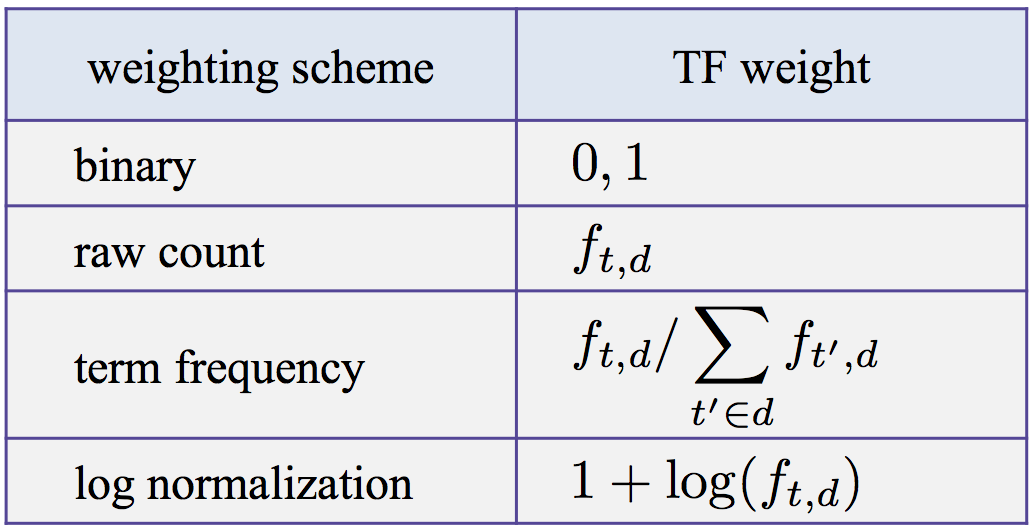

In [16]:
def term_frequency(documents,words):
    sentence_vectors = []
    for sentence in documents:
        sentence_tokens = nltk.word_tokenize(sentence)
        sent_vec = []
        for token in words:
            if token in sentence_tokens:
                sent_vec.append(len(token))
            else:
                sent_vec.append(0)

        term_frequency = [term/len(str(sentence).split(" ")) for term in sent_vec]
        sentence_vectors.append(term_frequency)

    term_frequency = pd.DataFrame(sentence_vectors)
    term_frequency.columns= words
    return term_frequency

term_frequency_start = term_frequency(asrs['report_1_new'],risky_words)

In [17]:
print(term_frequency_start.shape)
term_frequency_start.tail()

(252, 81)


,accident,airspeed,attitude,broke,broken,clipped,collapse,collision,communication,currency,...,miscommunication,damaged,deice,deiced,diverted,divert,fearing,feared,fail,failing
247,0.0,0.000000,0.0,0.0,0.021053,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,0.0,0.024768,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Text vectorization 2: Tf-idf

In [18]:
def binary_BOW(documents,words):
    sentence_vectors = []
    for sentence in documents:
        sentence_tokens = nltk.word_tokenize(sentence)
        sent_vec = []
        for token in words:
            if token in sentence_tokens:
                sent_vec.append(1)
            else:
                sent_vec.append(0)
        sentence_vectors.append(sent_vec)

    bag_of_words = pd.DataFrame(sentence_vectors)
    bag_of_words.columns= words
#    bag_of_words['risk_count']=bag_of_words.sum(axis =1)

    return(list(bag_of_words.transpose().apply(lambda x: dict(x))))
    
bag_of_words_start = binary_BOW(asrs['report_1_new'],risky_words)

In [19]:
# data frequency
def computeDF(documents):    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = float(val)
    return idfDict

dfs = computeDF(bag_of_words_start)

In [20]:
frequent_risky_words = dict()
for (key, value) in dfs.items():
    if value > 0:
        frequent_risky_words[key] = value
frequent_risky_words = frequent_risky_words.keys()

In [21]:
term_frequency_final = term_frequency(asrs['report_1_new'],frequent_risky_words)
bag_of_words_final = binary_BOW(asrs['report_1_new'],frequent_risky_words)

In [22]:
#inverse data frequency
def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

idfs = computeIDF(bag_of_words_final)

In [23]:
def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

tfidf = pd.DataFrame([computeTFIDF(term_frequency_final.iloc[i,:],idfs) for i in range(len(term_frequency_final))])

In [24]:
print(tfidf.shape)
tfidf.tail()

(252, 65)


,accident,airspeed,attitude,broke,broken,clipped,collapse,collision,communication,currency,...,collided,damaged,deice,deiced,diverted,divert,fearing,feared,fail,failing
247,0.0,0.000000,0.0,0.0,0.059397,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,0.0,0.058238,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.119784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Resampling & Seperate train and test dataset

In [25]:
BOW_model = pd.concat([asrs['riskiness'],term_frequency_final], axis = 1)
tfidf_model = pd.concat([asrs['riskiness'],tfidf], axis = 1)

In [26]:
#proportion before resampling
asrs['riskiness'].value_counts()

0.0    190
1.0     62
Name: riskiness, dtype: int64

In [27]:
#resample minority group to make the dataset more balanced
#after resampling, the majority is 5 times of minority
def re_sample(dataframe):
    minority = dataframe[dataframe['riskiness'] == 1]
    majority = dataframe[dataframe['riskiness'] == 0]
    minority_resampled = resample(minority, replace = True, n_samples = int(len(majority)), random_state = 123)
    new_dataframe = pd.concat([majority, minority_resampled])
    return(new_dataframe)

In [28]:
BOW_model = re_sample(BOW_model)
tfidf_model = re_sample(tfidf_model)
tfidf_model.riskiness.value_counts()

1.0    190
0.0    190
Name: riskiness, dtype: int64

In [29]:
y_BOW = BOW_model['riskiness']
X_BOW = BOW_model.drop(['riskiness'],axis = 1)
X_BOW_train, X_BOW_test, y_BOW_train, y_BOW_test = train_test_split(X_BOW,y_BOW, test_size=0.2, random_state=101)

y_tfidf = tfidf_model['riskiness']
X_tfidf = tfidf_model.drop(['riskiness'],axis = 1)
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y_tfidf, test_size=0.3, random_state=101)

## Riskiness Prediction
### Model1: Logistic regression

In [30]:
def logistic_reg(X_train,X_test,y_train,y_test, THRESHOLD):
    #fitting the model
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)
    LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
    
    Y_pred = np.where(model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
    
    print(classification_report(y_test,Y_pred))

In [31]:
print('Classification report for logistic regression with bag of words')
logistic_reg(X_BOW_train, X_BOW_test, y_BOW_train, y_BOW_test,0.5)

Classification report for logistic regression with bag of words
              precision    recall  f1-score   support

         0.0       0.48      0.86      0.62        36
         1.0       0.58      0.17      0.27        40

    accuracy                           0.50        76
   macro avg       0.53      0.52      0.44        76
weighted avg       0.54      0.50      0.44        76



/Users/crystal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [32]:
print('Classification report for logistic regression with Tf-idf')
logistic_reg(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test,0.5)

Classification report for logistic regression with Tf-idf
              precision    recall  f1-score   support

         0.0       0.67      0.24      0.35        59
         1.0       0.52      0.87      0.65        55

    accuracy                           0.54       114
   macro avg       0.59      0.56      0.50       114
weighted avg       0.59      0.54      0.49       114



/Users/crystal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


High precision means that an algorithm returned substantially more relevant results than irrelevant ones, while high recall means that an algorithm returned most of the relevant results.

### Model2: SVM Classifier

In [33]:
def svm_Classifier(X_train, X_test, y_train, y_test):
    #fitting the model
    clf = svm.SVC(kernel='linear') # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
    clf.fit(X_train, y_train)
    Y_pred = clf.predict(X_test)
    print(classification_report(y_test,Y_pred))

In [34]:
print('Classification report for SVM Classifier with bag of words')
svm_Classifier(X_BOW_train, X_BOW_test, y_BOW_train, y_BOW_test)

Classification report for SVM Classifier with bag of words
              precision    recall  f1-score   support

         0.0       0.47      1.00      0.64        36
         1.0       0.00      0.00      0.00        40

    accuracy                           0.47        76
   macro avg       0.24      0.50      0.32        76
weighted avg       0.22      0.47      0.30        76



/Users/crystal/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
print('Classification report for SVM Classifier with Tf-idf')
svm_Classifier(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test)

Classification report for SVM Classifier with Tf-idf
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        59
         1.0       0.48      1.00      0.65        55

    accuracy                           0.48       114
   macro avg       0.24      0.50      0.33       114
weighted avg       0.23      0.48      0.31       114



/Users/crystal/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Model3: Naive Bayes

In [36]:
def Naive_Bayes(X_train, X_test, y_train, y_test):
    #fitting the model
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    Y_pred = gnb.predict(X_test)
    print(classification_report(y_test,Y_pred))

In [37]:
print('Classification report for Naive_Bayes with bag of words')
Naive_Bayes(X_BOW_train, X_BOW_test, y_BOW_train, y_BOW_test)

Classification report for Naive_Bayes with bag of words
              precision    recall  f1-score   support

         0.0       0.64      0.19      0.30        36
         1.0       0.55      0.90      0.69        40

    accuracy                           0.57        76
   macro avg       0.60      0.55      0.49        76
weighted avg       0.59      0.57      0.50        76



In [38]:
print('Classification report for Naive_Bayes with Tf-idf')
Naive_Bayes(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test)

Classification report for Naive_Bayes with Tf-idf
              precision    recall  f1-score   support

         0.0       0.60      0.20      0.30        59
         1.0       0.50      0.85      0.63        55

    accuracy                           0.52       114
   macro avg       0.55      0.53      0.47       114
weighted avg       0.55      0.52      0.46       114



### Model4: Random Forest

In [39]:
def Random_Forest(X_train, X_test, y_train, y_test):
    #fitting the model
    rf = RandomForestClassifier(n_estimators= 100, oob_score=True, random_state=10)
    rf.fit(X_train, y_train)
    Y_pred = rf.predict(X_test)
    print(classification_report(y_test,Y_pred))

In [40]:
print('Classification report for Random_Forest with bag of words')
Random_Forest(X_BOW_train, X_BOW_test, y_BOW_train, y_BOW_test)

Classification report for Random_Forest with bag of words
              precision    recall  f1-score   support

         0.0       0.90      0.75      0.82        36
         1.0       0.80      0.93      0.86        40

    accuracy                           0.84        76
   macro avg       0.85      0.84      0.84        76
weighted avg       0.85      0.84      0.84        76



In [41]:
print('Classification report for Random_Forest with Tf-idf')
Random_Forest(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test)

Classification report for Random_Forest with Tf-idf
              precision    recall  f1-score   support

         0.0       0.92      0.75      0.82        59
         1.0       0.77      0.93      0.84        55

    accuracy                           0.83       114
   macro avg       0.84      0.84      0.83       114
weighted avg       0.85      0.83      0.83       114



### Classification using Random Forest and bag of words has the best performance

- Resources for model explanability:
https://www.kaggle.com/learn/machine-learning-explainability